# Импорт библиотек

In [3]:
# Импорт общих библиотек
import pandas as pd
import numpy as np

#Масштабирование
from sklearn.preprocessing import StandardScaler

# импорт библиотек машинного обучения
from sklearn.model_selection import (train_test_split, # для разделения данных на тренировочную и тестовую выборки
                                     GridSearchCV) #для подбора гиперпараметров методом сетки


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import pickle 
# Импорт библиотек для графической визуализации данных
import seaborn as sns


#ML регрессия
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.neighbors import KNeighborsRegressor # метод ближайших соседей
from sklearn.tree import DecisionTreeRegressor # решающее дерево
from sklearn.svm import SVR # метод опорных векторов

#метрики оценки качества моделей регрессии
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score)





# Импорт предобработанных данных

In [ ]:
!git clone https://github.com/usmaxnik-rgb/VKR_UMN_Modul_Predict

In [ ]:
X_united_full=pd.read_excel('/content/VKR_UMN_Modul_Predict/X_united_full.xlsx', index_col='Index')

In [5]:
X_united_full.columns

Index(['Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки',
       'Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2'],
      dtype='object')

# Подготовка к ML для прогноза прочности при растяжении

In [6]:
y=np.array(X_united_full['Прочность при растяжении, МПа'])
X=np.array(X_united_full.drop('Прочность при растяжении, МПа', axis=1))

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(812, 12)
(812,)
(203, 12)
(203,)


# Нормализация 

In [7]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Метрики оценки качества ML

In [8]:
def get_metrics_regression(model_list,
                           model_list_name,
                           X_test, y_test):

  #список с сметриками
  mean_absolute_error_list = []
  mean_squared_error_list = []
  r2_score_list = []

  #цикл по метрикам регрессии
  for i in range(len(model_list)):
    y_pred = model_list[i].predict(X_test)
    print(f'Метрики для модели {model_list_name[i]}')

    print('mae = ', mean_absolute_error(y_test, y_pred))
    print('mse = ', mean_squared_error(y_test, y_pred))
    print('r2', r2_score(y_test, y_pred))

    mean_absolute_error_list.append(round(mean_absolute_error(y_test, y_pred), 3))
    mean_squared_error_list.append(round(mean_squared_error(y_test, y_pred), 3))
    r2_score_list.append(round(r2_score(y_test, y_pred),3))

  #результирующая таблица для сравнения
  result_table = pd.DataFrame(index = model_list_name)
  result_table['mae'] = mean_absolute_error_list
  result_table['mse'] = mean_squared_error_list
  result_table['r2'] = r2_score_list

  return result_table

# Linear regression

In [9]:
# 1. Настройка GridSearchCV
lr = LinearRegression()
grid_params = {'fit_intercept': [True, False]}
grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=grid_params,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

# 2. Обучение
grid_lr.fit(X_train, y_train)

# 3. Вывод лучших параметров (с коррекцией знака)
print(f"Лучшая валидационная MAE = {-grid_lr.best_score_:.4f}")
print(f"Лучшие параметры = {grid_lr.best_params_}")

# 4. Извлекаем лучшую модель
best_model = grid_lr.best_estimator_

# 5. Предсказания на тесте
y_pred = best_model.predict(X_test)

# 6. Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# 7. Вывод результатов
print("\n=== Метрики на тестовой выборке ===")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# 8. Таблица результатов
result_table = pd.DataFrame({
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R²': [r2]
}, index=['LinearRegression (best)'])

print("\n", result_table)

Лучшая валидационная MAE = 348.6783
Лучшие параметры = {'fit_intercept': True}

=== Метрики на тестовой выборке ===
MAE:  343.1318
MSE:  190179.6664
RMSE: 436.0959
R²:   -0.0118

                                MAE            MSE        RMSE        R²
LinearRegression (best)  343.13183  190179.666369  436.095937 -0.011805


#kNN

In [10]:
# 1. Настройка GridSearchCV
knnR = KNeighborsRegressor()

grid_params = {
    'n_neighbors': [5, 10],
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'p': [1, 2, 3]  # параметр для minkowski (1=manhattan, 2=euclidean)
}

grid_knnR = GridSearchCV(
    estimator=knnR,
    param_grid=grid_params,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

# 2. Обучение
grid_knnR.fit(X_train, y_train)

# 3. Вывод лучших параметров (с коррекцией знака)
print(f"Лучшая валидационная MAE = {-grid_knnR.best_score_:.4f}")
print(f"Лучшие параметры = {grid_knnR.best_params_}")

# 4. Извлекаем лучшую модель
best_model = grid_knnR.best_estimator_

# 5. Предсказания на тесте
y_pred = best_model.predict(X_test)

# 6. Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# 7. Вывод результатов
print("\n=== Метрики на тестовой выборке ===")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# 8. Таблица результатов
result_table = pd.DataFrame({
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R²': [r2]
}, index=['LinearRegression (best)'])

print("\n", result_table)

Лучшая валидационная MAE = 356.3124
Лучшие параметры = {'metric': 'minkowski', 'n_neighbors': 10, 'p': 3}

=== Метрики на тестовой выборке ===
MAE:  357.5623
MSE:  199529.5211
RMSE: 446.6873
R²:   -0.0615

                                 MAE            MSE        RMSE        R²
LinearRegression (best)  357.562337  199529.521103  446.687274 -0.061549


# SVR

In [11]:
# Настройка GridSearchCV для SVR
svr = SVR()

grid_params = {
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],      # тип ядра
    'C': [1],             # параметр регуляризации
    'epsilon': [ 0.5, 1],   # ширина «трубы» для потерь
    'gamma': ['scale', 'auto', 0.1, 1]  # коэффициент ядра
}

grid_svr = GridSearchCV(
    estimator=svr,
    param_grid=grid_params,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Обучение на масштабированных данных
grid_svr.fit(X_train_scaled, y_train)


# Вывод лучших параметров (с коррекцией знака)
print(f"Лучшая валидационная MAE = {-grid_svr.best_score_:.4f}")
print(f"Лучшие параметры = {grid_svr.best_params_}")


# Извлекаем лучшую модель
best_model = grid_svr.best_estimator_


# Предсказания на тесте (на масштабированных данных!)
y_pred = best_model.predict(X_test_scaled)


# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


# Вывод результатов
print("\n=== Метрики на тестовой выборке ===")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


# Таблица результатов (обновлено название модели)
result_table = pd.DataFrame({
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R²': [r2]
}, index=['SVR (best)'])


print("\n", result_table)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Лучшая валидационная MAE = 339.9203
Лучшие параметры = {'C': 1, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'poly'}

=== Метрики на тестовой выборке ===
MAE:  340.0542
MSE:  187836.5228
RMSE: 433.4011
R²:   0.0007

                   MAE            MSE        RMSE        R²
SVR (best)  340.05423  187836.522828  433.401111  0.000661


# DTR

In [12]:
# 1. Настройка GridSearchCV для DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=42)

grid_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
}

grid_dtr = GridSearchCV(
    estimator=dtr,
    param_grid=grid_params,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

# 2. Обучение
grid_dtr.fit(X_train, y_train)

# 3. Вывод лучших параметров (с коррекцией знака)
print(f"Лучшая валидационная MAE = {-grid_dtr.best_score_:.4f}")
print(f"Лучшие параметры = {grid_dtr.best_params_}")

# 4. Извлекаем лучшую модель
best_model = grid_dtr.best_estimator_

# 5. Предсказания на тесте
y_pred = best_model.predict(X_test)

# 6. Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Используем np.sqrt для корректности
r2 = r2_score(y_test, y_pred)

# 7. Вывод результатов
print("\n=== Метрики на тестовой выборке ===")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


# 8. Таблица результатов (исправлено название модели)
result_table = pd.DataFrame({
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R²': [r2]
}, index=['Decision Tree Regressor (best)'])

print("\n", result_table)

Лучшая валидационная MAE = 351.0899
Лучшие параметры = {'criterion': 'absolute_error', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

=== Метрики на тестовой выборке ===
MAE:  342.8099
MSE:  192390.5289
RMSE: 438.6234
R²:   -0.0236

                                        MAE            MSE        RMSE  \
Decision Tree Regressor (best)  342.809878  192390.528929  438.623448   

                                      R²  
Decision Tree Regressor (best) -0.023568  


# RandomForest

In [13]:
# 1. Настройка GridSearchCV для RandomForestRegressor
rfr = RandomForestRegressor(random_state=42)

grid_params = {
    'n_estimators': [50, 100, 200],        # число деревьев
    'max_depth': [3, 5, 7, 10, None],     # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],     # мин. объектов для разбиения
    'min_samples_leaf': [1, 2, 4],       # мин. объектов в листе
    'max_features': ['sqrt', 'log2', None]  # число признаков для разбиения
}

grid_rfr = GridSearchCV(
    estimator=rfr,
    param_grid=grid_params,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=1  # вывод прогресса (опционально)
)

# 2. Обучение
grid_rfr.fit(X_train, y_train)

# 3. Вывод лучших параметров (с коррекцией знака)
print(f"Лучшая валидационная MAE = {-grid_rfr.best_score_:.4f}")
print(f"Лучшие параметры = {grid_rfr.best_params_}")

# 4. Извлекаем лучшую модель
best_model = grid_rfr.best_estimator_


# 5. Предсказания на тесте
y_pred = best_model.predict(X_test)


# 6. Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


# 7. Вывод результатов
print("\n=== Метрики на тестовой выборке ===")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


# 8. Таблица результатов (обновлено название модели)
result_table = pd.DataFrame({
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R²': [r2]
}, index=['Random Forest Regressor (best)'])

print("\n", result_table)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Лучшая валидационная MAE = 344.7117
Лучшие параметры = {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}

=== Метрики на тестовой выборке ===
MAE:  339.0258
MSE:  186333.4079
RMSE: 431.6635
R²:   0.0087

                                        MAE            MSE        RMSE  \
Random Forest Regressor (best)  339.025801  186333.407855  431.663535   

                                      R²  
Random Forest Regressor (best)  0.008658  


#Сравнение алгоритмов

In [14]:
model_list = [grid_lr, grid_knnR, grid_dtr, grid_svr, grid_rfr]
model_list_name = ['lr', 'knnr', 'dtr', 'svr', 'rfr']

In [15]:
model_table = get_metrics_regression(model_list, model_list_name, X_test_scaled, y_test)
model_table.to_excel('Model_tabele_Strange.xlsx', index=True)
model_table

Метрики для модели lr
mae =  1347.1784870081922
mse =  2004985.3058779046
r2 -9.667044595868783
Метрики для модели knnr
mae =  340.32776704089565
mse =  188020.96733245027
r2 -0.0003205697387633766
Метрики для модели dtr
mae =  550.9484946016345
mse =  444382.67502235324
r2 -1.3642316969596626
Метрики для модели svr
mae =  340.0542301889102
mse =  187836.52282797475
r2 0.0006607231160695726
Метрики для модели rfr
mae =  342.31010018850884
mse =  189071.68501213964
r2 -0.005910661752932533


,mae,mse,r2
lr,1347.178,2004985.306,-9.667
knnr,340.328,188020.967,-0.000
dtr,550.948,444382.675,-1.364
svr,340.054,187836.523,0.001
rfr,342.310,189071.685,-0.006


<Axes: >

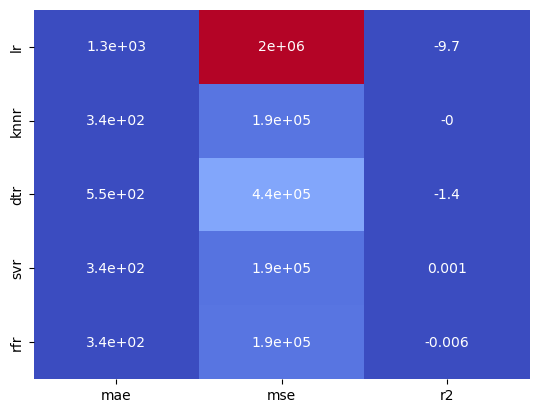

In [16]:
sns.heatmap(model_table, cmap = 'coolwarm', cbar = False, annot = True)

#Сохранение и загрузка моделей

In [24]:
#сохранение
with open('Strange_predict_model_svr.pkl', 'wb') as f:
  pickle.dump(grid_svr, f)

In [30]:
#загрузка моделей
with open('Strange_predict_model_svr.pkl', 'rb') as f:
  my_loaded_model_Strange = pickle.load(f)

# Тестирование выбранной модели

In [31]:
X_train1, X_test1, y_train1, y_test1=train_test_split(X,y, test_size=0.2, shuffle=True, random_state=42)

In [32]:
y_pred1 =grid_svr.predict(X_test1[:3])
print('y_pred =', y_pred1)

y_pred1 =my_loaded_model_Strange.predict(X_test1[:3])
print('y_pred =', y_pred1)

y_pred = [-1.41221279e+09 -2.12298027e+09 -1.76643726e+09]
y_pred = [-1.41221279e+09 -2.12298027e+09 -1.76643726e+09]
